In [3]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scripts.utils import get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, get_treatment_info, save_to_pickle, load_from_pickle
from datetime import datetime   


from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

import seaborn as sns
sns.set_theme(style='white')

#from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

from scipy.stats import zscore, spearmanr

import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()


color_dict = {
 'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
 }

regions = list(color_dict.keys())
region_colors = list(color_dict.values())

# Load a pandas dataframe with metadata (concatenated adata.obs dataframes)
all_obs = pd.read_csv('./data/pathology_filtered_obs_with_regions.csv',index_col=0)

## Region-specific markers (differential gene expression analysis)

### Calculate differential expression in individual regions and individual samples

In [ ]:
# Calculate DEGs between regions within individual samples
# This takes several minutes (method=wilcoxon)
for sample in tqdm(samples, desc="Processing sample", unit="sample"):

    slide = sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')
    slide.uns['log1p']["base"] = None # https://github.com/scverse/scanpy/issues/2239

    # Remove a group if it has less than 10 spots in it
    val_counts = slide.obs['predicted_region'].value_counts()
    category_groups = val_counts[~(val_counts < 10)].index.tolist()

    sc.tl.rank_genes_groups(slide,groupby='predicted_region', method='wilcoxon',groups=category_groups,random_state=25813063)

    slide.write_h5ad('./data/visium_with_regions_and_degs/'+sample+'_with_regions_and_degs.h5ad')

    


In [ ]:

masked_sample_ids = get_sample_id_mask()
# Take a region one at a time, extract DEG results, save into a list
# Create a dictionary and save appropriate dataframes
region_degs_dict = {}
for region in regions:
    deg_res_all = pd.DataFrame()
    region_degs_dict[region] = deg_res_all


for sample in tqdm(samples, desc="Processing sample", unit="sample"):

    slide = sc.read_h5ad(('./data/visium_with_regions_and_degs/'+sample+'_with_regions_and_degs.h5ad'))
    
    for region in regions:

        try:
            deg_res = sc.get.rank_genes_groups_df(slide,group=region)

            deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Remove ribosomal genes
            deg_res = deg_res[~deg_res['names'].str.startswith('MT')] # Remove mitochondrial genes
            deg_res['sample'] = masked_sample_ids[sample]
            deg_res = deg_res[(deg_res['pvals_adj']<0.05) & (deg_res['logfoldchanges']>=1)].reset_index(drop=True)

            region_degs_dict[region] = pd.concat([region_degs_dict[region].copy(),deg_res],axis=0)

        except:
            continue

    del slide


# Save the sample/region-specific DEGs
date = datetime.now().strftime('%y%m%d')
save_to_pickle(region_degs_dict,'./data/region_gene_markers_signif_degs_'+date+'.pkl')

In [ ]:
# Save the results into an excel-file

# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/region_specific_markers_individual_samples.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in region_degs_dict.items():
    # Write each dataframe to a separate sheet in the Excel file
    value['sample'] = value['sample'].map(sample_id_masks)
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()


## Fisher's exact test of individual gene markers

In [2]:
date = '240229'
region_degs_dict = load_from_pickle('./data/region_gene_markers_signif_degs_'+date+'.pkl')

region_sample_counts = {}
df_gene_counts = pd.DataFrame()
for r in regions:
    df_gene_counts = pd.merge(region_degs_dict[r]['names'].value_counts().rename(r),df_gene_counts,left_index=True,right_index=True,how='outer')
    region_sample_counts[r] = len(region_degs_dict[r]['sample'].unique())
df_gene_counts = df_gene_counts.fillna(0).astype(int)


In [4]:
# Take DEG results and perform enrichment analysis:
# Check in how many samples this gene is overexpressed in a specific region
# Compare this to how many samples the same gene is overexpressed in 
# If there is a significant enrichment for this marker in a region, it can be considired region specific

signif_pval_interactions = {}

for reg in tqdm(regions,unit='region'):
    
    df = df_gene_counts.copy()
    other_keys = [c for c in df.columns if c != reg]

    n_sample = region_sample_counts[reg]
    n_control = pd.Series([region_sample_counts[k] for k in other_keys]).sum()

    df = df.sort_index()

    # Perform Fisher's exact test on all 
    for iact in df.index:
        a = df[reg].loc[[iact]]
        c = df[other_keys].sum(axis=1).loc[[iact]]
        b = n_sample-a
        d = n_control-c
        arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
        stat,pval = fisher_exact(arr,alternative='greater')
        df.loc[[iact],'pval'] = pval

    df['adj_pval'] = multipletests(df['pval'],method='fdr_bh')[1]


    df_signif = pd.DataFrame({'interaction':df.index.tolist(),
                                'active_in':df[reg].astype(int).tolist(),
                                'adj_pval':df['adj_pval'].tolist(),
                                'interface':np.repeat(reg,len(df))})

    signif_pval_interactions[reg] = df_signif.copy()


date = datetime.now().strftime('%y%m%d')
save_to_pickle(signif_pval_interactions,'./data/region_gene_markers_fishers_exact_test_'+date+'.pkl')

100%|██████████| 8/8 [04:52<00:00, 36.57s/region]


### Format into dataframes and save into an excel file

In [ ]:
# Get the number of regions in each sample and save into a dataframe

df = all_obs[['sample_id','predicted_region']].copy()
df['sample_id'] = df['sample_id'].map(sample_id_masks)
df['sample_id']= df['sample_id'].astype('category').cat.reorder_categories(sample_id_masks.values())
df['count'] = 1
region_counts_df  = df.groupby(['sample_id','predicted_region']).agg({'count':'sum'})

# Save sample-specific region abundances into an excel file
writer = pd.ExcelWriter('./supplementary_tables/region_prevalences_in_all_samples.xlsx', engine='xlsxwriter')
region_counts_df.to_excel(writer)
writer.save()

In [ ]:
# Format the region Fisher's exact to a dataframe
for reg in regions:

    n_valid_samples = (region_counts_df.loc[region_counts_df.index.get_level_values(1) == reg]['count'] >=10).sum()
    df = signif_pval_interactions[reg].copy()

    df = df.drop(columns='interface')
    df.columns = ['gene', 'over-expressed in (out of {:d} region-containing samples)'.format(n_valid_samples), 'adjusted p-value (Fishers exact test)']
    df = df.sort_values('adjusted p-value (Fishers exact test)').reset_index(drop=True)
    signif_pval_interactions[reg] = df


# Save the results into an excel-file
# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/supp_table_with_region_marker_fishers.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in signif_pval_interactions.items():
    # Write each dataframe to a separate sheet in the Excel file
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()

### Create a dotplot of canonical region-specific markers (Figure 1c)

In [5]:
region_degs_dict = load_from_pickle('./data/region_gene_markers_signif_degs_240229.pkl')

# Define gene markers 
marker_genes_for_hmap = ['PRAC1','HPN','PCAT14','AMACR','PCA3', # Tumor
                         'MSMB','ACPP','RDH11','NKX3-1','AZGP1', # Luminal
                         'KRT5','KRT15','TRIM29','TP63','SLC14A1', # Basal 
                         'MMP7','PIGR','LTF','CP','KRT7', # Club
                         'CXCR4','TRBC1','CD3D','LYZ','CD79A', # Immune
                         'EPAS1','EMP1','VWF','PECAM1','IFI27', # Endothelium
                         'DCN','LUM','FBLN1','SFRP2','COL1A1', # Fibroblast
                         'TAGLN','ACTA2','ACTG2','MYH11','MYL9' # Muscle
                         ]

In [6]:
# Create the dotplot structure
plot_df = pd.DataFrame()
for region in regions:
    degs = region_degs_dict[region]
    n_samples = len(degs['sample'].unique())
    
    degs = degs[degs['names'].isin(marker_genes_for_hmap)]
    
    mean_lfc_list = []
    proportion_degs_list = []

    for gene in marker_genes_for_hmap:

        if gene in degs['names'].values:
            mean_lfc = degs[degs['names'] == gene]['logfoldchanges'].mean()
            proportion_degs = degs['names'].value_counts()[gene] / n_samples
            mean_lfc_list.append(mean_lfc)
            proportion_degs_list.append(proportion_degs)
        
        else:
            mean_lfc_list.append(np.nan)
            proportion_degs_list.append(0)
    
    df = pd.DataFrame({'mean_logfoldchange': mean_lfc_list,'pct_deg_in': proportion_degs_list, 'region': region},index = marker_genes_for_hmap)
    plot_df = pd.concat([plot_df,df],axis=0)

plot_df['genes'] = plot_df.index.astype(str)

plot_df.loc[plot_df['pct_deg_in']==0,'pct_deg_in'] = np.nan

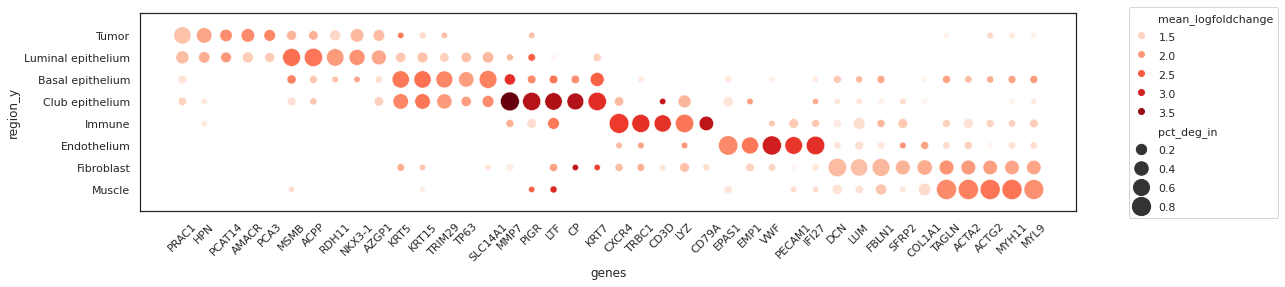

In [7]:
# Create the dotplot
sns.set(style='white')

width = 18
height = 4

fig, ax = plt.subplots(figsize=(width, height))
yticks_list = list(np.arange(2,(len(regions)*2)+2,2)[::-1])

# Get control over interactions order and gap
plot_df['region_y'] = plot_df['region'].map(dict(zip(regions,yticks_list)))
sns.scatterplot(x='genes', y='region_y', size='pct_deg_in', hue='mean_logfoldchange', 
                data=plot_df, sizes=(40, 400), palette='Reds', ax=ax,legend=True,
                )

plt.ylim(0,yticks_list[0]+2)
plt.yticks(yticks_list,regions)
plt.xticks(rotation=45)
plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

plt.savefig('./plots/region_gene_markers_dotplot.pdf',transparent=True)
plt.show()

# Save the plot source data
plot_df.to_excel('./source_data/figure_1c.xlsx',index=False)

## Boxplot to compare region pcts across categories (Figure 2d)

In [10]:
treat_info = get_treatment_info()
concat_obs = all_obs.copy()
concat_obs['treatment'] = concat_obs['sample_id'].map(treat_info)

def get_spot_proportions(region,sample_list=samples,obs_df=all_obs,treatment_info=treat_info, re_annotate_treated=True):
    df = pd.DataFrame(index=sample_list,columns=[region + ' spots','total spots','treatment'])
    for sample in sample_list:
        sample_df = obs_df[obs_df['sample_id'] == sample].copy()
        df.loc[sample,'total spots'] = len(sample_df)
        df.loc[sample,region + ' spots'] = len(sample_df[sample_df['predicted_region'] == region])
    df['proportion'] = df[region+' spots'] / df['total spots']
    df['treatment'] = df.index.map(treatment_info)

    if re_annotate_treated:
        # Re-annotate
        df['treatment'] = df['treatment'].replace({'bicalutamide':'treated','goserelin':'treated','degarelix':'treated','degarelix_apalutamide':'treated'})

    df['treatment'] = df['treatment'].astype('category')    
    df['proportion'] = df['proportion'].astype(float)

    return(df)


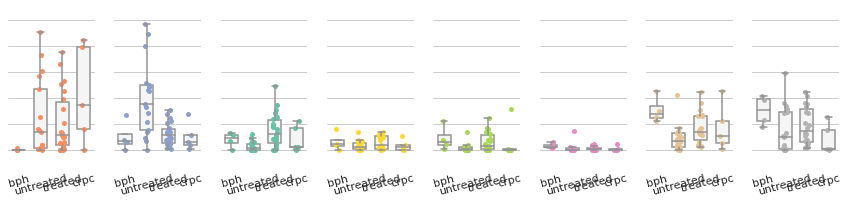

In [16]:
sns.set_theme(style='whitegrid')

order = ['bph', 'untreated', 'treated','crpc']

# All data saved into this
plot_df_list = []
fig, axs = plt.subplots(1,8,figsize=(12,3))
for i, region in enumerate(regions):
    ax = axs[i]
    df = get_spot_proportions(region)

    sns.stripplot(x="treatment", y="proportion", order = order, data=df, size=5, ax=ax, color=color_dict[region]) # color=".7",)
    sns.boxplot(showmeans=False,
            meanline=False,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': True},
            whiskerprops={'visible': True},
            zorder=10,
            x="treatment",
            y="proportion",
            data=df,
            order = order,
            showfliers=False,
            showbox=True,
            showcaps=True,
            color='whitesmoke',
            width=0.6,
            ax=ax)
    ax.set_ylim(-0.1,1.1)
    #ax.set_title(region)
    ax.set_ylabel('')
    ax.set_xlabel('')
    #ax.set_xticklabels([''])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=15)
    ax.set_yticklabels([''])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    df = df.rename(columns={f'{region} spots':'spots in region'})
    df['region'] = region

    plot_df_list.append(df)

plot_df = pd.concat(plot_df_list)
plt.tight_layout()
plt.savefig('./plots/region_proportion_swarmplots/all_region_proportions_swarmplot_boxplot.pdf') # 6.3.2024 added boxplot
plt.show()

# Save the plot source data
plot_df.index = plot_df.index.map(sample_id_masks)
plot_df.to_excel('./source_data/figure_2d.xlsx')



In [17]:
# Perform statistical testing of possible differences in spot proportions between samples
# Use these to draw significance bars on top of the swarmplots

from scipy.stats import kruskal,ranksums

# Set to print the dataframe p-values as a specific format
pd.set_option('display.float_format', lambda x: '%.1e' % x)

for region in regions:
    df = get_spot_proportions(region)
    df['treatment'] = df['treatment'].cat.reorder_categories(['bph','untreated','treated','crpc'])

    # extract the values and categories from the dataframe
    values = df['proportion']
    categories = df['treatment']

    # perform the Kruskal-Wallis test
    statistic, p_value = kruskal(*[values[categories == cat] for cat in set(categories)])

    print(region)
    # print the results
    print("Kruskal-Wallis test")
    print("p-value: {:.3f}".format(p_value))

    if p_value < 0.05:
        treatments = df['treatment'].cat.categories
        res_df = pd.DataFrame(np.eye(len(treatments),len(treatments)),index=treatments,columns=treatments)

        for i in range(len(treatments)):
            for j in range(i+1, len(treatments)):
                # Get data for the two treatments being compared
                data1 = df.loc[df['treatment'] == treatments[i], 'proportion']
                data2 = df.loc[df['treatment'] == treatments[j], 'proportion']
                
                # Perform Mann-Whitney U test
                stat, pval = ranksums(data1, data2)
                
                # Print results
                res_df.loc[treatments[i],treatments[j]] = pval
                res_df.loc[treatments[j],treatments[i]] = pval
        print('Wilcoxon rank-sum test:')
        print(res_df)
    print('')

Tumor
Kruskal-Wallis test
p-value: 0.028
Wilcoxon rank-sum test:
              bph  untreated  treated    crpc
bph       1.0e+00    7.2e-03  4.5e-03 1.1e-01
untreated 7.2e-03    1.0e+00  9.3e-01 3.7e-01
treated   4.5e-03    9.3e-01  1.0e+00 2.4e-01
crpc      1.1e-01    3.7e-01  2.4e-01 1.0e+00

Luminal epithelium
Kruskal-Wallis test
p-value: 0.002
Wilcoxon rank-sum test:
              bph  untreated  treated    crpc
bph       1.0e+00    3.2e-02  4.3e-01 1.0e+00
untreated 3.2e-02    1.0e+00  9.2e-04 1.7e-02
treated   4.3e-01    9.2e-04  1.0e+00 3.5e-01
crpc      1.0e+00    1.7e-02  3.5e-01 1.0e+00

Basal epithelium
Kruskal-Wallis test
p-value: 0.004
Wilcoxon rank-sum test:
              bph  untreated  treated    crpc
bph       1.0e+00    7.3e-02  3.2e-01 1.0e+00
untreated 7.3e-02    1.0e+00  4.4e-04 1.7e-01
treated   3.2e-01    4.4e-04  1.0e+00 2.6e-01
crpc      1.0e+00    1.7e-01  2.6e-01 1.0e+00

Club epithelium
Kruskal-Wallis test
p-value: 0.470

Immune
Kruskal-Wallis test
p-value: 

## Differential expression TRNA vs NEADT

#### Done in scripts/neadt_vs_trna_degs_script.py

In [67]:
# Load the results and check genes

region_degs_dict = {}

for region in regions:
    df = pd.read_excel('./supplementary_tables/NEADT_vs_TRNA_degs_by_region.xlsx',sheet_name=region,index_col=0)
    region_degs_dict[region] = df


In [ ]:
# Save only those that pass the DEG threshold
# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/NEADT_vs_TRNA_degs_by_region_log2fc_filtered.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in region_degs_dict.items():
    # Write each dataframe to a separate sheet in the Excel file
    value = value[(value['pvals_adj'] < 0.05) & (np.abs(value['logfoldchanges']) >= 1)].reset_index(drop=True)

    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()


## Spatial plots in a grid (Supplementary)

### UMI counts on spatial sections 6x8

In [21]:
sns.set_theme(style='white')

it=0
fig, axs = plt.subplots(6, 8, figsize=(16, 12),dpi=300)

for i in tqdm(range(6),desc='Row completion'):
    for j in range(8):
        
        if it < len(samples):

            sample_name = samples[it]
            
            slide = sc.read_h5ad('./data/visium_with_regions/'+sample_name+'_with_regions.h5ad')
            sc.pp.calculate_qc_metrics(slide,layer='counts',inplace=True)

            if 'P320' in sample_name:
                sc.pl.spatial(slide,color='total_counts',
                        #crop_coord=sample_crop_coord[sample_name],
                        title='',
                        size=1.5, alpha_img=0, legend_loc=None,
                        ax=axs[i,j],
                        show=False,
                        cmap='viridis',
                        colorbar_loc=None,
                        vmax=25000
                        )
            else:
                sc.pl.spatial(slide,color='total_counts',
                        title='',
                        crop_coord=sample_crop_coord[sample_name],
                        size=1.5, alpha_img=0, legend_loc=None,
                        ax=axs[i,j],
                        show=False,
                        cmap='viridis',
                        colorbar_loc=None,
                        vmax=25000
                        )
                
            del slide
                
            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)


plt.tight_layout()


plt.savefig('./plots/UMI_counts_all_samples_spatial.pdf',dpi=120)
plt.clf()
#plt.show()


Row completion: 100%|██████████| 6/6 [00:52<00:00,  8.75s/it]


<Figure size 4800x3600 with 0 Axes>

### Regions on spatial sections 6x8

In [26]:
sns.set_theme(style='white')

it=0
fig, axs = plt.subplots(6, 8, figsize=(16, 12))

for i in tqdm(range(6),desc='Row completion'):
    for j in range(8):
        
        if it < len(samples):

            sample_name = samples[it]
            
            slide = sc.read_h5ad('./data/visium_with_regions/'+sample_name+'_with_regions.h5ad')

            if 'P320' in sample_name:

                sc.pl.spatial(slide,color='predicted_region',title='',
                    #    crop_coord=sample_crop_coord[sample_name],
                        size=1.5, alpha_img=0.0, legend_loc=None, # Old 1.3 and 0.8
                        ax=axs[i,j],show=False
                        )
            else:
                sc.pl.spatial(slide,color='predicted_region',title='',
                        crop_coord=sample_crop_coord[sample_name],
                        size=1.5, alpha_img=0.0, legend_loc=None, # Old 1.3 and 0.8
                        ax=axs[i,j],show=False
                        )
                
            del slide
                
            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)


plt.tight_layout()


plt.savefig('./plots/regions_all_samples_spatial_6x8.pdf',dpi=120)
plt.clf()
#plt.show()


Row completion: 100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


<Figure size 1152x864 with 0 Axes>

### Tissue H&E

In [ ]:
sns.set_theme(style='white')
sample_id_mask_dict = get_sample_id_mask()
samples = list(sample_id_mask_dict.keys())

it=0
fig, axs = plt.subplots(10, 5, figsize=(15, 30),dpi=300)

for i in tqdm(range(10),desc='Row completion'):
    for j in range(5):
        
        if it < len(samples):

            sample_name = samples[it]
            
            slide = sc.read_h5ad('./data/visium_with_regions/'+sample_name+'_with_regions.h5ad')

            if 'P320' in sample_name:
                sc.pl.spatial(slide,color='predicted_region',title=sample_id_mask_dict[sample_name],
                        #    crop_coord=sample_crop_coord[samples[it]],
                            size=0, alpha_img=1, legend_loc=None,
                            ax=axs[i,j],show=False
                            )

            else:
                sc.pl.spatial(slide,color='predicted_region',title=sample_id_mask_dict[sample_name],
                        crop_coord=sample_crop_coord[sample_name],
                        size=0, alpha_img=1, legend_loc=None,
                        ax=axs[i,j],show=False
                        )
                
            del slide
                
            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)

plt.tight_layout()


plt.savefig('./plots/HE_all_samples_spatial.png',dpi=120)
plt.clf()
#plt.show()


### Regions one sample at a time

In [ ]:
for sample in tqdm(samples, desc="Processing sample", unit="sample"):
    
    it=0

    fig, axs = plt.subplots(2, 4, figsize=(12, 6),dpi=300)

    slide = sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')

    for i in range(2):
        for j in range(4):
        
            region_of_interest = regions[it]

            if region_of_interest in slide.obs['predicted_region'].unique():
                
                slide.obs['region_of_interest'] = np.nan

                slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

                slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

                slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

            
                n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]

                sc.pl.spatial(slide,color='region_of_interest',title=region_of_interest+ ' ({:d})'.format(n_spots),
                        crop_coord=sample_crop_coord[sample],
                        size=1.5, alpha_img=0.0, legend_loc=None,na_color='whitesmoke', # Changed from 0.8
                        ax=axs[i,j],show=False
                        )
                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)

            else:
                axs[i,j].set_visible(False)
            
            it+=1
    
    plt.tight_layout()
    plt.savefig('./plots/all_samples_grid/region_based/sample_specific/'+sample+'_all_regions_individually.pdf')
    plt.clf()
    #plt.show()
